This notebook is meant to document and also reproduce the exploratory data analysis we've done on the results from our pipeline [ALPINE](https://github.com/nrminor/ALPINE), which is designed to identify high-interest pathogens in large databases. The notebook will walk readers through this exploratory analysis, data visualizations, and statistics at a more relaxed pace than our upcoming manuscript.

With that introduction out of the way, let's introduce what ALPINE actually does.

### Introduction to ALPINE
ALPINE, an acronym for *Anachronistic Lineage and Persistent INfection Explorer*, is a high-throughput, reproducible pipeline for discovering pathogen sequences with either of the following characteristics:
1. The pathogen sequence is highly mutated relative to co-occurring pathogen sequences, indicating that it evolved a great deal in ways that more common pathogen variants haven't.
2. The pathogen hails from a lineage that is no longer circulating, or at least no longer prevalent. The most parsimonious explanation for this "past-their-time" pathogens is that they have persisted in a long infection of an immunocompromised person, though it's also possible that these sequences stem from pathogens that have spilled back from animal reservoirs.

ALPINE generates very rich results, with sequence data and metadata for highly evolved sequences, anachronistic sequences, and sequences that are in the Venn overlap between the two. Rather than digging through these results haphazardly, this notebook is meant to establish a workflow for digging through them. Data visualizations and statistics will be baked in. A manuscript for ALPINE is in preparation now, but we think of this notebook as complementary/serving a different purpose. By going through and running the code in this notebook yourself, you will effectively reproduce not just the results, but also the figures we generated for the manuscript.

### Software requirements
In addition to the software required to run this notebook, you'll also need two applications installed:
1. Poetry, which is an excellent Python environment manager. [You can read more and install it here.](https://python-poetry.org/docs/)
2. At least Python 3.10. `alpineexplorer` uses structural pattern matching (`match`-`case` blocks) to handle errors, a feature which was only introduced in Python 3.10. That said, we recommend users upgrade to 3.11 if possible.
3. Docker, which we use for some intermediate analyses with [Usher](https://usher-wiki.readthedocs.io/en/latest/UShER.html) and [NextClade](https://docs.nextstrain.org/projects/nextclade/en/latest/index.html)

Once those are installed, you'll be ready to proceed.

### Initial Foray into the Data

First, we make sure the packages required by this repo are installed and the core functions are in place.

In [1]:
!poetry install

Installing dependencies from lock file

Package operations: 6 installs, 0 updates, 0 removals

  • Installing click-plugins (1.1.1): Pending...
  • Installing cligj (0.7.2): Pending...
  • Installing cligj (0.7.2): Downloading... 0%
  • Installing cligj (0.7.2): Downloading... 0%
  • Installing click-plugins (1.1.1): Downloading... 0%
  • Installing cligj (0.7.2): Downloading... 0%
  • Installing cligj (0.7.2): Downloading... 100%
  • Installing cligj (0.7.2): Installing...
  • Installing cligj (0.7.2): Installing...
  • Installing click-plugins (1.1.1): Downloading... 100%
  • Installing cligj (0.7.2): Installing...
  • Installing cligj (0.7.2): Installing...
  • Installing click-plugins (1.1.1): Installing...
  • Installing cligj (0.7.2): Installing...
  • Installing cligj (0.7.2)
  • Installing cligj (0.7.2)
  • Installing click-plugins (1.1.1)
  • Installing cligj (0.7.2)
  • Installing fiona (1.9.5): Pending...
  • Installing pyproj (3.6.1): Pending...
  • Installing shapely (2.0.

Next, let's load some of the libraries we may use in our explorations (all of which are listed and versioned in `pyproject.toml`). These are only available because Poetry handled the installations above.

In [50]:
import os
import sys
import glob
from result import Result, Ok, Err
import polars as pl
import matplotlib.pyplot as plt
import seaborn
import scipy
import numpy
import pandas
import geopandas as gpd
import alpineexplorer.main as ae

You'll notice we load a module called `ALPINEExplorer`; this is only available because we activated the environment in this directory, where there is, in fact, a module named "ALPINEExplorer". You could not access this module outside the current working directory unless you specified back to this directory's environment with Poetry.

Next, let's specify a constant for the path to our results (be sure to change this to wherever the results are located on your machine!). We'll also use an assert statement to double check that the provided path actually exists and is a directory.

In [41]:
RESULTS_DIR="/path/to/results"
assert os.path.exists(RESULTS_DIR) and os.path.isdir(
        RESULTS_DIR
    ), "Provided file path does not exist or is not a directory."

Next, let's compile a table of mutations to look at and generate some visualizations. First, we generate a dictionary of subdirectory paths, which will be traversed downstream. I use the Python `result` module along with structural pattern matching in the module, but here, let's just unwrap the results.

In [42]:
starter_paths = ae.construct_file_paths(RESULTS_DIR).unwrap()

If you'd to see what the starter paths look like, uncomment the following and run it.

In [43]:
# starter_paths

Now, let's take that dictionary and turn it into a true "tree" of directories to traverse. This tree is itself a dictionary, where the keys are all the geographies ALPINE searched, and the values are a data structure listing all the relevant subdirectories for that geography.

In [44]:
search_tree = ae.define_search_tree(starter_paths).unwrap()

In [45]:
# search_tree

Let's now take that search tree and actually use it to search:

In [46]:
stats_df = ae.stats_pipeline(search_tree).unwrap()

You'll notice that function compiled all the relevant stats for each geography and returned a data frame so we can continue to look at it. Before we proceed, let's save the stats dataframe to an Excel file:

In [47]:
stats_df.write_excel("alpine_run_statistics.xlsx", autofit=True)



Next, let's use the search tree to compile databases of metadata for each kind of candidate, which we can then group by geography and query as needed. To do this, we'll blend reading and writing of the files with a conversion to the more efficient Arrow format, which we can then read again later. To do so, we just run the following function on the search tree. The function will return [Polars LazyFrames](https://pola-rs.github.io/polars/py-polars/html/reference/lazyframe/index.html) that we can query later.

In [48]:
meta_results = ae.compile_metadata(search_tree).unwrap()
anachron_meta = meta_results.anachron
highdist_meta = meta_results.highdist
double_meta = meta_results.double

### Basic Visualizations
We'll start where most exploratory data analyses start: with a histogram. We'll start with a histogram of both the counts and the prevalences of some of the ALPINE candidates.

### Mapping the Results

/var/folders/9x/674wjx_j0_18sq2xr6zsnd900000gq/T/ipykernel_94289/1599157845.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


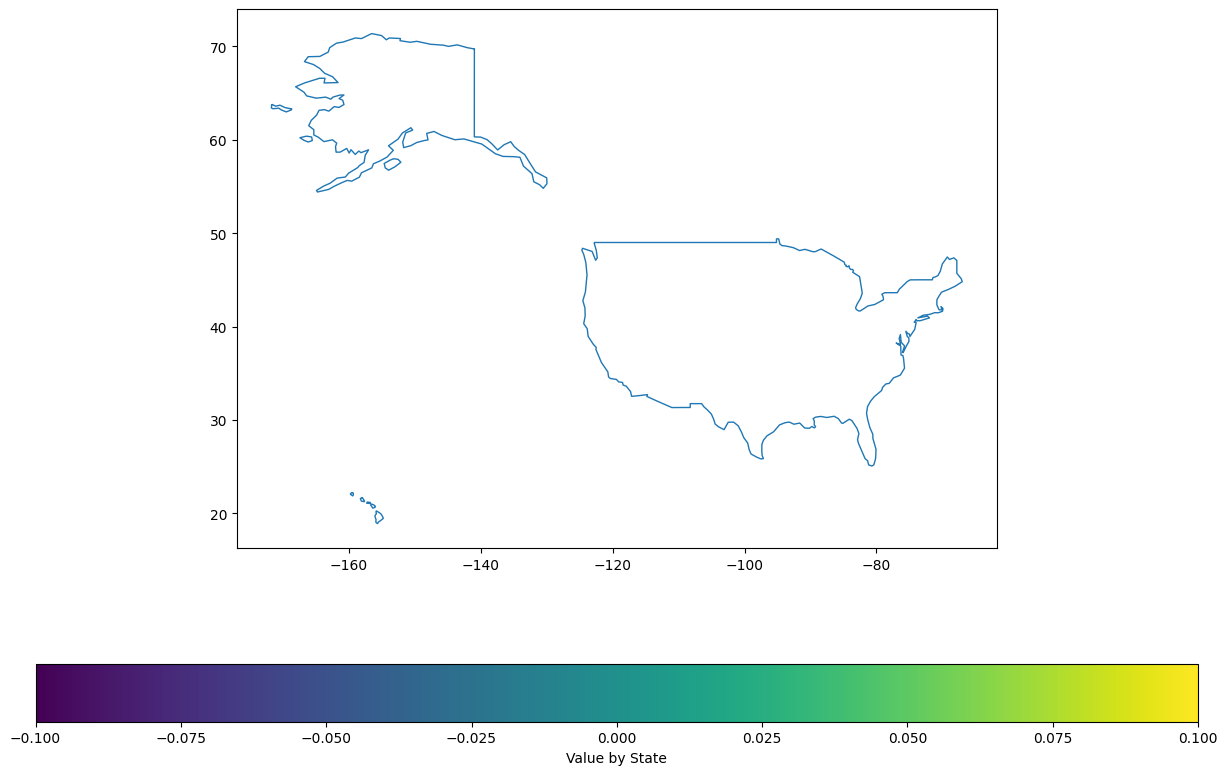

In [52]:
stats_pd = stats_df.to_pandas()

# Load the U.S. states shapefile included in geopandas
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for the United States
gdf = gdf[gdf['iso_a3'] == 'USA']

# Merge the GeoDataFrame with the DataFrame
merged = gdf.set_index('name').join(stats_pd.set_index('Geography'))

# Plot the map
fig, ax = plt.subplots(1, figsize=(15, 10))
merged.boundary.plot(ax=ax, linewidth=1)
merged.plot(column='Double Candidate Count', ax=ax, legend=True,
            legend_kwds={'label': "Double Candidate Count by State",
                         'orientation': "horizontal"})
plt.show()